In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import pandas as pd
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt


import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [2]:
path = "/workspace/melee_project_data/input_np/mango/FALCO/72a00ff5-b2a2-4afa-9b63-9523feaf9beb.npy.gz"

with gzip.open(path, 'rb') as f:
            segment = np.load(f)

for n in range(5,9):
    print(np.unique(segment[n,:]))

[0.]
[0. 1.]
[0. 1.]
[0. 1.]


In [3]:
path = "/workspace/melee_project_data/input_np/mango/FALCO/72a00ff5-b2a2-4afa-9b63-9523feaf9beb.npy.gz"

with gzip.open(path, 'rb') as f:
            segment = np.load(f)

for n in range(5,9):
    print(np.unique(segment[n,:]))
    print('ones:', np.sum(segment[n,:]), ', zeros:', segment.shape[1] - np.sum(segment[n,:]))

# print(segment)

[0.]
ones: 0.0 , zeros: 10604.0
[0. 1.]
ones: 1023.0 , zeros: 9581.0
[0. 1.]
ones: 944.0 , zeros: 9660.0
[0. 1.]
ones: 1731.0 , zeros: 8873.0


In [4]:
path = "/workspace/melee_project_data/input_np/mango/FALCO/e55c959c-533d-4b0e-82b1-4e79decd25e2.npy.gz"

with gzip.open(path, 'rb') as f:
            segment = np.load(f)

for n in range(5,9):
    print(np.unique(segment[n,:]))
    print('ones:', np.sum(segment[n,:]), ', zeros:', segment.shape[1] - np.sum(segment[n,:]))




[0. 1.]
ones: 56.0 , zeros: 18805.0
[0. 1.]
ones: 1706.0 , zeros: 17155.0
[0. 1.]
ones: 1644.0 , zeros: 17217.0
[0. 1.]
ones: 3769.0 , zeros: 15092.0


In [5]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [6]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

df = dataset.dataset

df.head()

/workspace/slp_jaspar/extract_all_data/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...,5606,FALCO
1,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...,5754,FALCO
2,POKEMON_STADIUM,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...,6213,MARTH
3,FOUNTAIN_OF_DREAMS,2,True,FOX,HUMAN,HUMAN,mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...,7621,FOX
4,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...,7840,FALCO


In [7]:
sample_df = df.sample(n=10000, random_state=42)
print(sample_df.shape)
print(sample_df.describe())
sample_df.head()

(10000, 9)
       num_players        length
count      10000.0  10000.000000
mean           2.0   9979.344900
std            0.0   2860.188563
min            2.0    736.000000
25%            2.0   8050.000000
50%            2.0   9721.000000
75%            2.0  11642.000000
max            2.0  28475.000000


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
348967,YOSHIS_STORY,2,True,FOX,HUMAN,HUMAN,public\FOX\a122b7ea-3e82-4a06-b291-8730da634f7...,8724,FOX
106415,BATTLEFIELD,2,True,FOX,HUMAN,HUMAN,ranked\FOX\63b5c152-30ed-4559-8653-1d3c5f01348...,11818,FOX
1550,FINAL_DESTINATION,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\d3a9aa12-7b4b-4431-8acc-9733e38ceb...,10926,MARTH
75533,BATTLEFIELD,2,True,JIGGLYPUFF,HUMAN,HUMAN,ranked\JIGGLYPUFF\10c25234-fa19-43e7-906f-14bb...,8050,JIGGLYPUFF
377755,BATTLEFIELD,2,True,YOUNG_LINK,HUMAN,HUMAN,public\YOUNG_LINK\b9f1c238-d627-4cc8-b561-76e8...,11433,YOUNG_LINK


In [8]:
data_key = { 
    'JSTICK_X':[],
    'JSTICK_Y':[], 
    'CSTICK_X':[], 
    'CSTICK_Y':[],  
    'TRIGGER_LOGICAL':[],  
    'Z':[],  
    'A':[],  
    'B':[], 
    'X_or_Y':[]
}

def load_and_process(path, length, row_sums_dict):
    
    with gzip.open(path, 'rb') as f:
            inputs = np.load(f)
    
    
    # Want a new dictionary with each the sum of each row of inputs being added the values of data_key
    row_sums_np = np.sum(np.abs(inputs), axis=1) / length
    # Map each sum to the corresponding key in data_key
    keys = row_sums_dict.keys()
    for index, key in enumerate(keys):
        row_sums_dict[key].append(row_sums_np[index])
    
    row_sums_dict.update(row_sums_dict)
    return 

row_sums_dict = data_key.copy()
for i in range(sample_df.shape[0]):
# for i in range(3):
    load_and_process('/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\','/'),sample_df['length'].iloc[i],row_sums_dict)

row_sums_df = pd.DataFrame(row_sums_dict)
# print(row_sums_df.head())
row_sums_df.describe()
    
    

,JSTICK_X,JSTICK_Y,CSTICK_X,CSTICK_Y,TRIGGER_LOGICAL,Z,A,B,X_or_Y
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.470227,0.228387,0.022926,0.023903,0.168122,0.009042,0.060897,0.046072,0.096898
std,0.068022,0.051974,0.018190,0.018235,0.050291,0.012963,0.033187,0.031164,0.043688
min,0.008833,0.002656,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.426483,0.193147,0.010996,0.011939,0.132579,0.001749,0.036574,0.021636,0.068716
50%,0.469291,0.226423,0.018295,0.019313,0.165243,0.004635,0.054197,0.039768,0.088737
75%,0.512404,0.262021,0.029540,0.031152,0.200973,0.010278,0.079302,0.064217,0.115284
max,0.779890,0.478192,0.234361,0.472544,0.402314,0.144998,0.281173,0.211693,0.350917


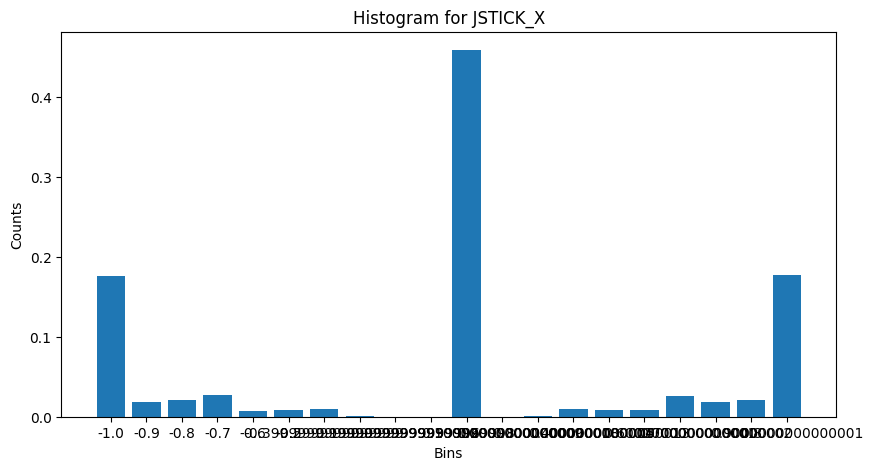

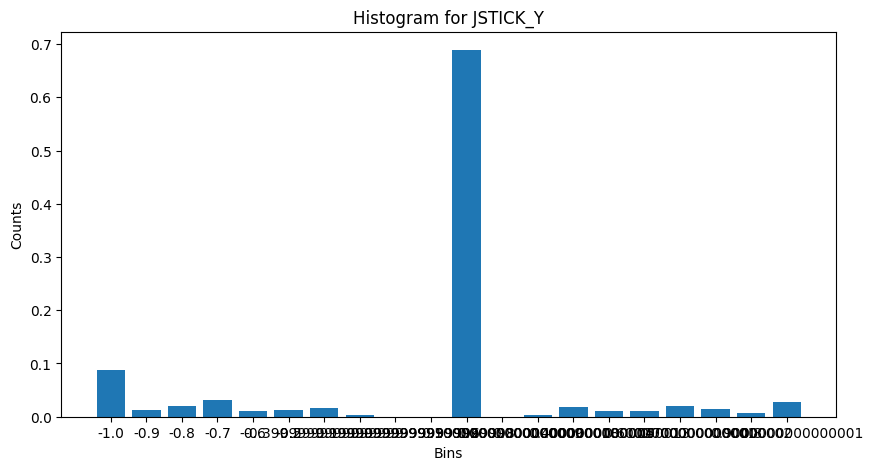

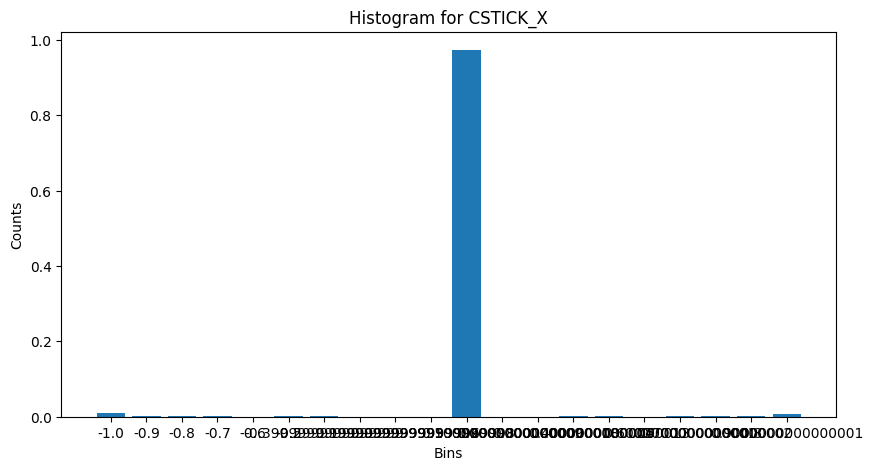

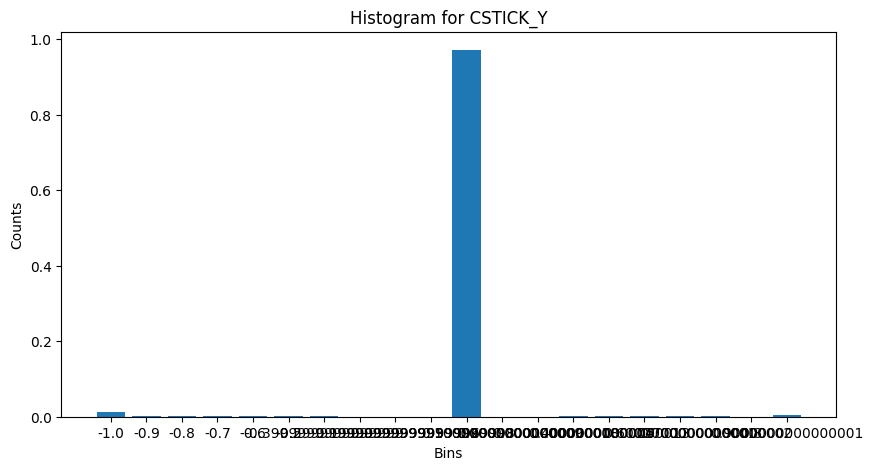

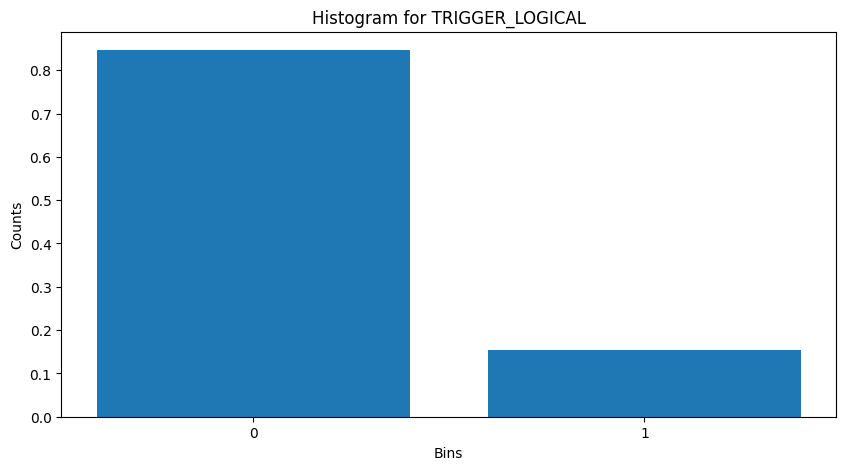

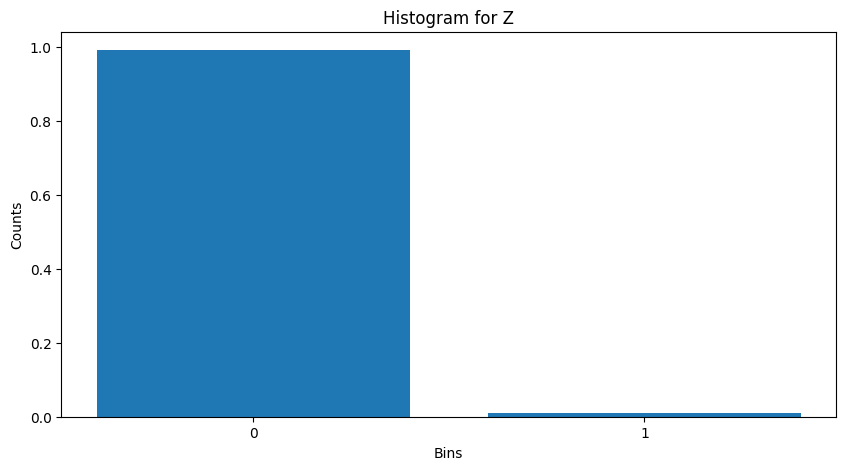

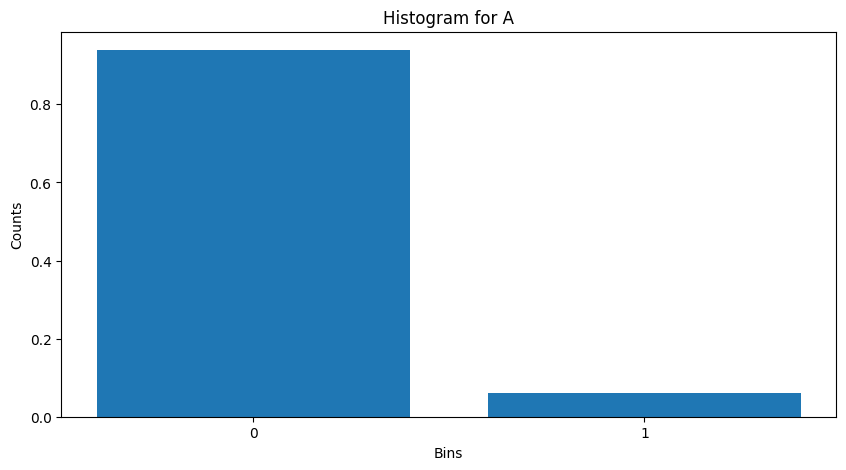

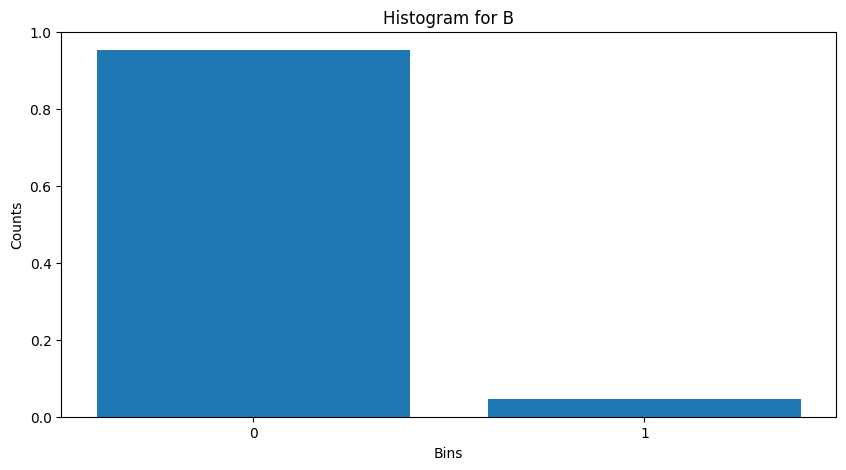

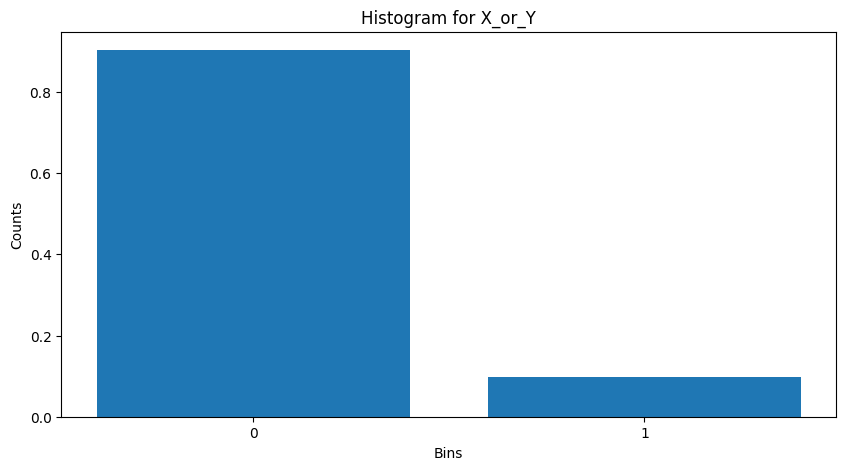

In [9]:
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define input keys
input_keys = ['JSTICK_X', 'JSTICK_Y', 'CSTICK_X', 'CSTICK_Y', 'TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
binary_keys = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']

# Initialize global histograms with appropriate bin edges
bin_edges = {
    key: np.linspace(-1, 1, 21) if key not in binary_keys else np.array([0, 1, 2])
    for key in input_keys
}
global_histograms = {key: np.zeros(len(bin_edges[key]) - 1) for key in input_keys}

def load_and_process(path, length, histograms):
    with gzip.open(path, 'rb') as f:
        inputs = np.load(f)

    # Ensure inputs have the correct number of columns
    if inputs.shape[0] != len(input_keys):
        raise ValueError(f"Expected number of columns: {len(input_keys)}, but got {inputs.shape[0]}")

    # Compute histograms for each column
    for index, key in enumerate(input_keys):
        row_histogram, _ = np.histogram(inputs[index,:], bins=bin_edges[key])
        histograms[key] += row_histogram / length

# Example DataFrame loading and processing loop
# sample_df = pd.read_csv('path_to_your_dataframe.csv')
for i in range(sample_df.shape[0]):
    path = '/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\', '/')
    load_and_process(path, sample_df['length'].iloc[i], global_histograms)

# Display histograms
for key, counts in global_histograms.items():
    plt.figure(figsize=(10,5))
    plt.title(f'Histogram for {key}')
    plt.bar(range(len(counts)), counts / sample_df.shape[0], tick_label=bin_edges[key][:-1])
    plt.xlabel('Bins')
    plt.ylabel('Counts')
    plt.show()
